In [1]:
import pandas as pd
import numpy as np
import pickle
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import plot_roc_curve
from sklearn import datasets, metrics, model_selection

from keras.models import Sequential
from keras.layers import Dense,  Activation
from keras.regularizers import L1L2
from keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from scipy import stats
import seaborn as sns

Using TensorFlow backend.


In [2]:
####Reading data from csv files of neighborhoods
output_feats = 'flat_neighbourhoods_full.csv'
df_iter = pd.read_csv(output_feats,header=None,index_col=0)
len(df_iter)

#print(df_iter)
X_all = df_iter.iloc[:, :124]
y_all = df_iter.iloc[:, 124:]
print(len(X_all))
print(len(y_all))

X_all = StandardScaler().fit_transform(X_all)
X_sel,X_test, y_sel, y_test = \
        train_test_split(X_all, y_all, test_size=300,random_state=42)

print(len(X_sel),len(X_test))
X_tr, y_tr = 0,0

7200
7200
6900 300


In [30]:
y_all.shape

(7200, 1)

In [4]:
####Definition of MLP-LR classifier in Keras
def MLP_LR_NN (X_train,y_train):
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    model = Sequential()

    model.add(Dense(124, activation='relu',kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                   input_dim = len(X_train[0])))
    model.add(Dense(1,  # output dim is 2, one score per each class
                    activation='sigmoid',
                    kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                    input_dim=20))  # input dimension = number of features your data has
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train, encoded_Y, epochs=70, batch_size = 20,verbose = 0)
    return model,history

####Plotting accuracy
def plot_data(dat,plotWhat,y_label,title):
    
    d1 = pd.DataFrame(columns = ['classifier', 'n', plotWhat, 'color'])

    k = 0
    for ni in np.unique(dat['n']):
        for cl in np.unique(dat['classifier']):

            tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', plotWhat]]
            se = stats.sem(tmp[plotWhat].astype(float))
            list(tmp.mean())
            d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
            k += 1


    sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
    fig, ax = plt.subplots(figsize = (8,6))

    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        ax = grp.plot(ax=ax, kind='line', x='n', y=plotWhat, label=key, \
                c = names[key], alpha =0.65)
        #ax.set_xscale('log')

    plt.legend(loc='top left',title='Algorithm')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Number of Training Samples')
    plt.show()

In [5]:
y_sel.shape

(6900, 1)

In [8]:
###Training
names = {"MLP-LR": "black", "LR":"blue", "MLP-relu-LR":'red'}

ncores=1
num_runs=5
n_est=100
filename = 'Non_linear_classification_full3.csv'

classifiers = [MLPClassifier(hidden_layer_sizes = 4,activation = 'logistic', alpha=1, max_iter=1000),
               LogisticRegression(max_iter=2000),
               MLP_LR_NN (X_sel,y_sel)
    ]

# Train each classifier on each data set size, then test
## Prep output file:
f = open(filename, 'w+')
f.write("classifier,n,Accuracy,trainTime,testTime,iterate\n")
f.flush()

ns = np.array([10,100,1900,2900,4900,6900])
runList = [(clf) for clf in zip(classifiers, [key for key in names])]
for n in tqdm(ns):
    print (n)
    for iteration in tqdm(range(num_runs)):
        
        #sampling of data
        X_train = X_sel[:n]
        y_train = np.array(y_sel[:n]).ravel()
        
        #X = X_train2[:n,:]
        #y = Y_train2[:n]

        print (iteration)
        for clf in tqdm(runList):
            
            if(clf[1] == "MLP-relu-LR" ):
                trainStartTime = time.time()
                cls,his = MLP_LR_NN (X_train,y_train)
                trainEndTime = time.time()
                trainTime = trainEndTime - trainStartTime
                encoder = LabelEncoder()
                encoder.fit(y_test)
                en_y_test = encoder.transform(y_test)
                
                testStartTime = time.time()
                score = cls.evaluate(X_test, en_y_test, batch_size=20)
                testEndTime = time.time()
                testTime = testEndTime - testStartTime
                acc=score[1]
            else:
                #training
                trainStartTime = time.time()
                clf[0].fit(X_train, y_train)
                trainEndTime = time.time()
                trainTime = trainEndTime - trainStartTime
                #prediction
                testStartTime = time.time()
                out = clf[0].predict(X_test)
                testEndTime = time.time()
                testTime = testEndTime - testStartTime
                #accuracy
                acc = accuracy_score(y_test,out)

            
            #writing to file
            ####("variable,num of training samples,Lhat,avg precision,trainTime,testTime,iterate")
            f.write(f"{clf[1]}, {n}, {acc:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
            f.flush()
f.close()

C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

10
0
300/300 [==============================] - 0s 209us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]

 20%|████████████████▏                                                                | 1/5 [00:00<00:03,  1.08it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  6.15it/s]

300/300 [==============================] - 0s 183us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]

 40%|████████████████████████████████▍                                                | 2/5 [00:02<00:03,  1.08s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]



2


 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  6.68it/s]

300/300 [==============================] - 0s 103us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]

 60%|████████████████████████████████████████████████▌                                | 3/5 [00:03<00:02,  1.17s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|███████████████████████████                                          

3
300/300 [==============================] - 0s 198us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.84it/s]

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [00:04<00:01,  1.14s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4
300/300 [==============================] - 0s 103us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.41it/s]

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

100
0
300/300 [==============================] - 0s 123us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]

 20%|████████████████▏                                                                | 1/5 [00:01<00:05,  1.28s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1
300/300 [==============================] - 0s 95us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]

 40%|████████████████████████████████▍                                                | 2/5 [00:02<00:03,  1.29s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████               

2
300/300 [==============================] - 0s 155us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]

 60%|████████████████████████████████████████████████▌                                | 3/5 [00:03<00:02,  1.24s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|███████████████████████████                                          

3
300/300 [==============================] - 0s 106us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [00:05<00:01,  1.34s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4
300/300 [==============================] - 0s 102us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1900
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:01,  1.85it/s]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:00<00:00,  2.31it/s]

300/300 [==============================] - 0s 213us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.24s/it]

 20%|████████████████▏                                                                | 1/5 [00:09<00:38,  9.74s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:00<00:01,  1.48it/s]

300/300 [==============================] - 0s 100us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]

 40%|████████████████████████████████▍                                                | 2/5 [00:19<00:28,  9.60s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  3.56it/s]

300/300 [==============================] - 0s 110us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.02s/it]

 60%|████████████████████████████████████████████████▌                                | 3/5 [00:28<00:18,  9.44s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

3




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  2.79it/s]

300/300 [==============================] - 0s 103us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.16s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [00:37<00:09,  9.45s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4




 33%|███████████████████████████                                                      | 1/3 [00:01<00:01,  1.00it/s]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:00,  1.37it/s]

300/300 [==============================] - 0s 100us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.23s/it]

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2900
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:01,  1.23it/s]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:00<00:00,  1.65it/s]

300/300 [==============================] - 0s 121us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.77s/it]

 20%|████████████████▏                                                                | 1/5 [00:14<00:57, 14.32s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.13s/it]

300/300 [==============================] - 0s 120us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.88s/it]

 40%|████████████████████████████████▍                                                | 2/5 [00:28<00:43, 14.42s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.41s/it]

300/300 [==============================] - 0s 96us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.60s/it]

 60%|████████████████████████████████████████████████▌                                | 3/5 [00:42<00:28, 14.24s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

3




 33%|███████████████████████████                                                      | 1/3 [00:00<00:01,  1.19it/s]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:00<00:00,  1.60it/s]

300/300 [==============================] - 0s 96us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.91s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [00:57<00:14, 14.39s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4




 33%|███████████████████████████                                                      | 1/3 [00:00<00:01,  1.48it/s]

300/300 [==============================] - 0s 113us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.30s/it]

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4900
0




 33%|███████████████████████████                                                      | 1/3 [00:01<00:03,  1.58s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:01,  1.17s/it]

300/300 [==============================] - 0s 103us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.34s/it]

 20%|████████████████▏                                                                | 1/5 [00:22<01:28, 22.04s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.15s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:00,  1.09it/s]

300/300 [==============================] - 0s 100us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.84s/it]

 40%|████████████████████████████████▍                                                | 2/5 [00:45<01:07, 22.49s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.12s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:00,  1.15it/s]

300/300 [==============================] - 0s 113us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.71s/it]

 60%|████████████████████████████████████████████████▌                                | 3/5 [01:08<00:45, 22.68s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

3




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.15s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:00,  1.17it/s]

300/300 [==============================] - 0s 100us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.61s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [01:31<00:22, 22.73s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.39s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:01,  1.03s/it]

300/300 [==============================] - 0s 120us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.90s/it]

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

6900
0




 33%|███████████████████████████                                                      | 1/3 [00:01<00:03,  2.00s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:02<00:01,  1.50s/it]

300/300 [==============================] - 0s 150us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.00s/it]

 20%|████████████████▏                                                                | 1/5 [00:33<02:12, 33.01s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:01<00:03,  1.59s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:01,  1.23s/it]

300/300 [==============================] - 0s 110us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.78s/it]

 40%|████████████████████████████████▍                                                | 2/5 [01:05<01:38, 32.81s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2




 33%|███████████████████████████                                                      | 1/3 [00:01<00:03,  1.59s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:02<00:01,  1.27s/it]

300/300 [==============================] - 0s 108us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.80s/it]

 60%|████████████████████████████████████████████████▌                                | 3/5 [01:37<01:05, 32.69s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

3




 33%|███████████████████████████                                                      | 1/3 [00:02<00:04,  2.26s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:02<00:01,  1.70s/it]

300/300 [==============================] - 0s 96us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.46s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [02:09<00:32, 32.30s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

4




 33%|███████████████████████████                                                      | 1/3 [00:01<00:02,  1.15s/it]

 67%|██████████████████████████████████████████████████████                           | 2/3 [00:01<00:00,  1.09it/s]

300/300 [==============================] - 0s 100us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [06:45<00:00, 67.65s/it]


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


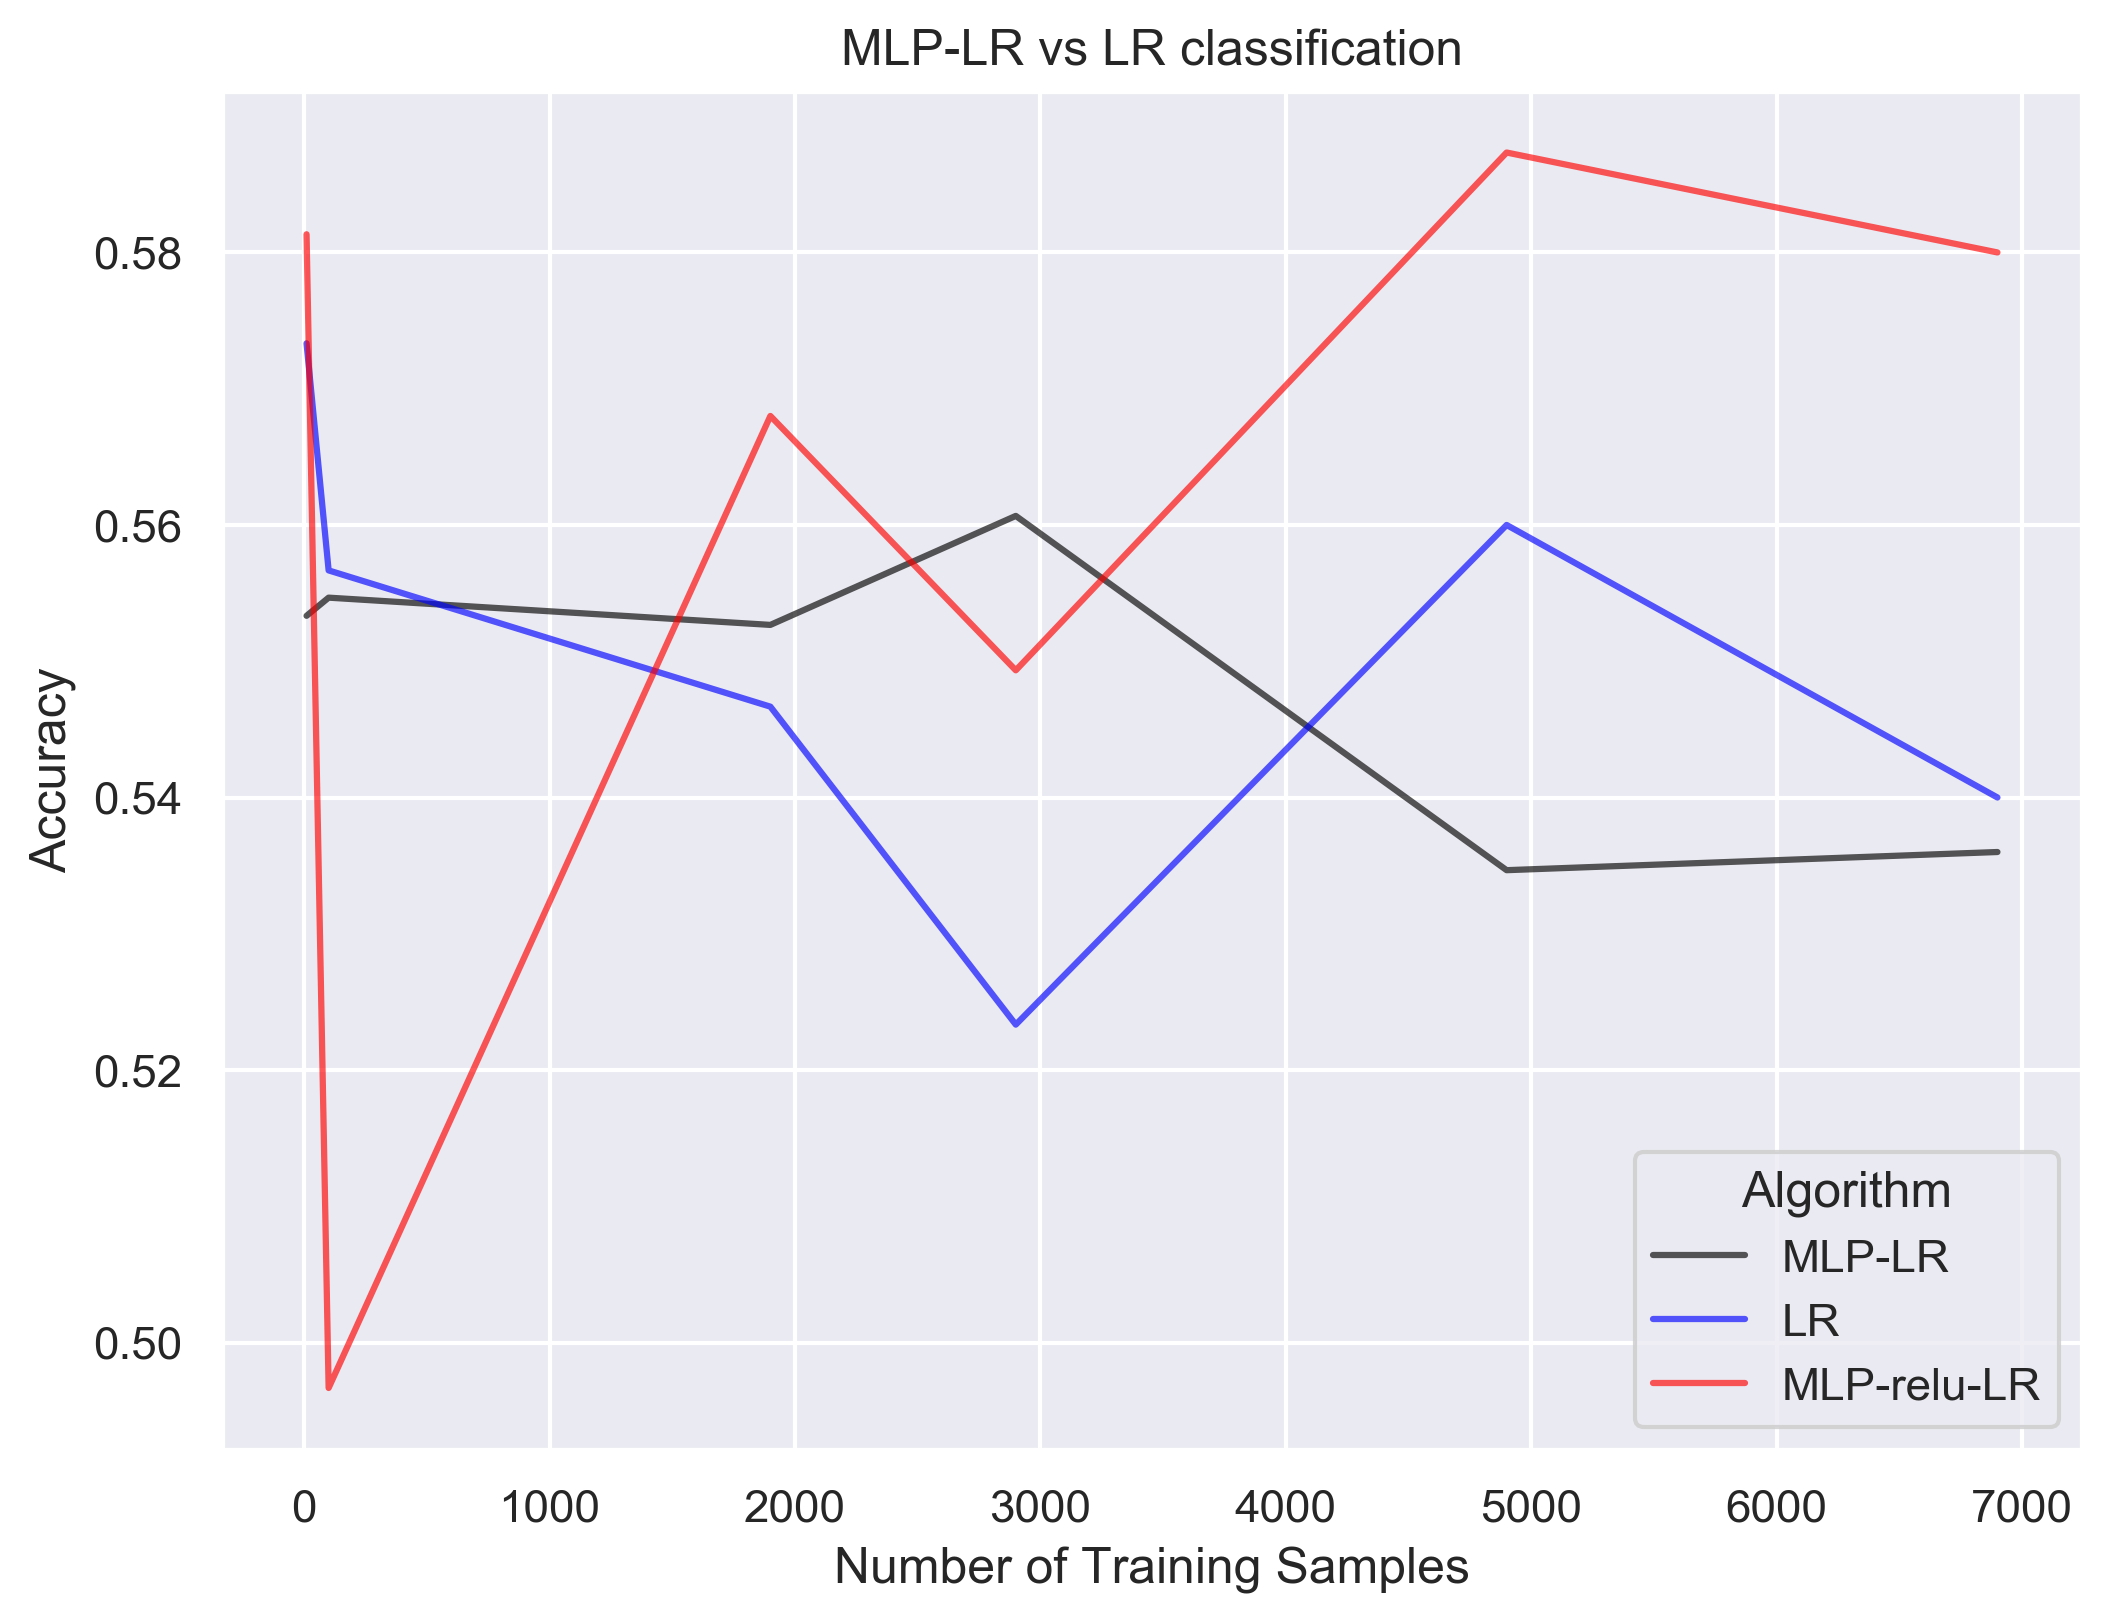

In [9]:
#names = {"kNN": "black", "RF":"blue", "MLP":"green", "S-RerF":"red"}
#filename = 'Non_linear_classification1.csv'
dat = pd.read_csv(filename)

##Plot Average Precision
plot_data(dat,'Accuracy','Accuracy','MLP-LR vs LR classification')